# NLP Project: Language Modeling Comparison
In this notebook is our code for the NLP Project 1_2. We begin 


## 0. Setup and Imports


In [7]:
import re
import html
import string
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Optional, Union
from wordcloud import WordCloud
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate

# Setup Visuals
sns.set_style("whitegrid")

# display plots directly
%matplotlib inline 

# Download resources if checks fail
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
    
print("Libraries loaded.")



Libraries loaded.


## Task 1: Data Analysis

In [8]:
# Data loading and minimal cleaning
df = pd.read_csv("IMDB Dataset.csv") 

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

def clean_text(text):
    text = text.lower()
    text = re.sub(r"<br\s*/?>", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].head()


,review,clean_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...","petter mattei's ""love in the time of money"" is..."


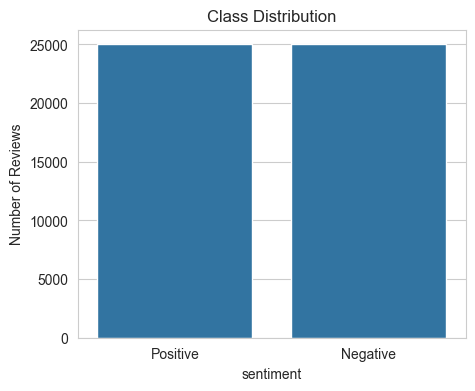

sentiment
1    25000
0    25000
Name: count, dtype: int64

In [9]:
# Class distribution
class_counts = df['sentiment'].value_counts()

plt.figure(figsize=(5,4))
sns.barplot(x=class_counts.index.map({1:"Positive",0:"Negative"}), y=class_counts.values)
plt.title("Class Distribution")
plt.ylabel("Number of Reviews")
plt.show()

class_counts

In [10]:
# Length statistics and distribution
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))

length_stats = df.groupby('sentiment')['word_count'].agg(['mean', 'median', 'std']).rename(index={1:'Positive',0:'Negative'})
length_stats

,mean,median,std
sentiment,,,
Negative,227.11432,172.0,163.185663
Positive,230.62320,171.0,175.751225


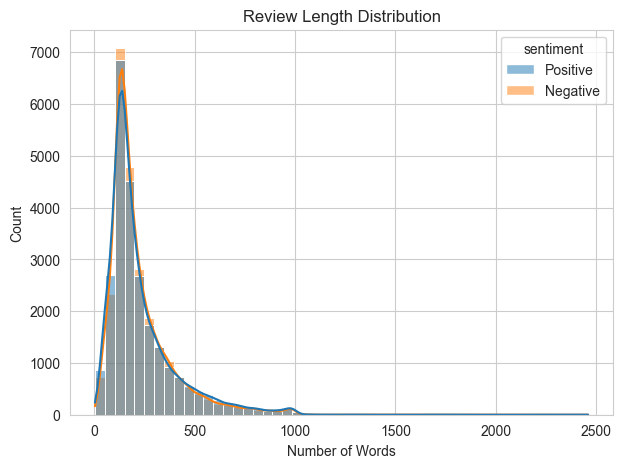

In [11]:
plt.figure(figsize=(7,5))
sns.histplot(
    data=df,
    x='word_count',
    hue=df['sentiment'].map({1:"Positive", 0:"Negative"}),
    bins=50,
    kde=True
)
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.show()


In [12]:
# Most frequent content words per class

def top_content_words(texts, n=20):
    c = Counter()
    for doc in texts:
        for w in doc.split():
            if w.isalpha() and w not in stop_words:
                c[w] += 1
    return pd.DataFrame(c.most_common(n), columns=["word", "count"])

top_pos_content = top_content_words(df[df.sentiment==1]["clean_review"], n=20)
top_neg_content = top_content_words(df[df.sentiment==0]["clean_review"], n=20)

display(top_pos_content)
display(top_neg_content)


,word,count
0,film,29392
1,movie,26710
2,one,23685
3,like,16441
4,good,11872
5,great,11234
6,see,11097
7,really,10351
8,would,10301
9,also,9788


,word,count
0,movie,34844
1,film,25744
2,one,22056
3,like,21032
4,even,14796
5,would,13537
6,good,11704
7,really,11493
8,bad,10676
9,see,9909


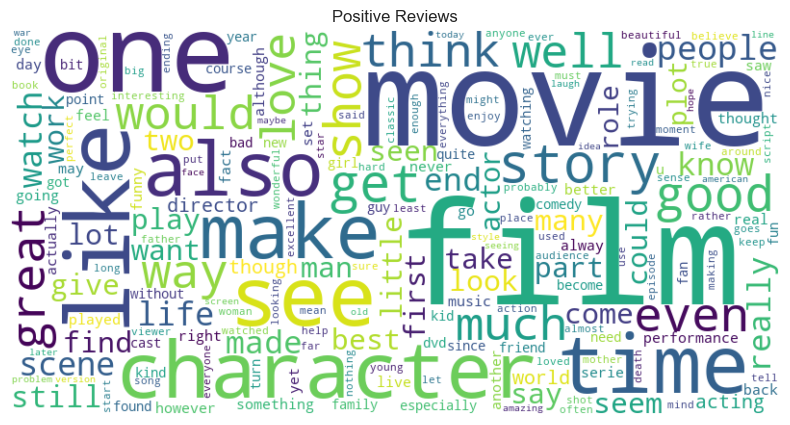

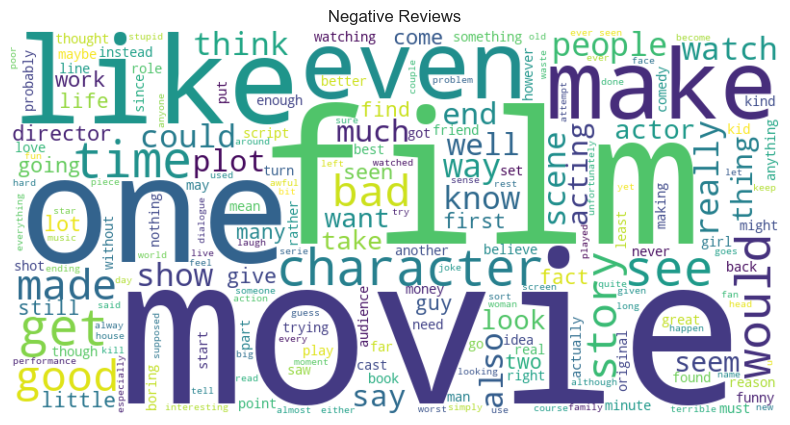

In [13]:
# Word Clouds per class

def plot_wordcloud(text, title):
    wc = WordCloud(
        width=800, height=400,
        stopwords=stop_words,
        background_color="white"
    ).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(" ".join(df[df.sentiment==1]['clean_review']), "Positive Reviews")
plot_wordcloud(" ".join(df[df.sentiment==0]['clean_review']), "Negative Reviews")


In [14]:
# N-gram frequencies

def get_ngram_frequencies(df, n=2, min_df=20, stop_words=None):
    """
    Computes n-gram frequencies for the entire dataset + per class.
    """
    
    vect = CountVectorizer(
        ngram_range=(n, n),
        min_df=min_df,
        stop_words=stop_words
    )
    X = vect.fit_transform(df["clean_review"])
    ngrams = vect.get_feature_names_out()

    pos_mask = (df['sentiment'] == 1).to_numpy()
    neg_mask = (df['sentiment'] == 0).to_numpy()

    total_counts = np.asarray(X.sum(axis=0)).ravel()
    
    overall_df = (
        pd.DataFrame({"ngram": ngrams, "count": total_counts})
          .sort_values("count", ascending=False)
          .reset_index(drop=True)
    )
    
    # per class
    pos_counts = X[pos_mask].sum(axis=0).A1
    neg_counts = X[neg_mask].sum(axis=0).A1
    
    pos_df = (
        pd.DataFrame({"ngram": ngrams, "count": pos_counts})
          .sort_values("count", ascending=False)
          .reset_index(drop=True)
    )
    
    neg_df = (
        pd.DataFrame({"ngram": ngrams, "count": neg_counts})
          .sort_values("count", ascending=False)
          .reset_index(drop=True)
    )
    
    return overall_df, pos_df, neg_df



In [15]:
# Bigram frequencies

bigrams_all, bigrams_pos, bigrams_neg = get_ngram_frequencies(
    df,
    n=2,
    min_df=20,
    stop_words=list(stop_words)
)

display(bigrams_all.head(20))
display(bigrams_pos.head(20))
display(bigrams_neg.head(20))


,ngram,count
0,ever seen,2709
1,special effects,2248
2,even though,1999
3,one best,1904
4,low budget,1823
5,looks like,1641
6,year old,1598
7,waste time,1509
8,see movie,1500
9,much better,1497


,ngram,count
0,one best,1671
1,even though,1099
2,ever seen,976
3,first time,960
4,new york,855
5,special effects,806
6,must see,778
7,see movie,767
8,real life,761
9,years ago,741


,ngram,count
0,ever seen,1733
1,special effects,1442
2,waste time,1437
3,looks like,1234
4,low budget,1229
5,much better,1009
6,one worst,957
7,look like,943
8,year old,914
9,bad movie,905


In [16]:
# Trigram frequencies

trigrams_all, trigrams_pos, trigrams_neg = get_ngram_frequencies(
    df,
    n=3,
    min_df=10,
    stop_words=list(stop_words)
)

display(trigrams_all.head(20))
display(trigrams_pos.head(20))
display(trigrams_neg.head(20))

,ngram,count
0,movie ever seen,526
1,worst movie ever,469
2,movies ever seen,380
3,one worst movies,308
4,worst movies ever,282
5,new york city,277
6,world war ii,231
7,films ever seen,225
8,film ever seen,222
9,movie ever made,209


,ngram,count
0,new york city,195
1,world war ii,167
2,one best movies,142
3,based true story,135
4,movie ever seen,133
5,one best films,129
6,first time saw,115
7,movies ever seen,112
8,films ever made,99
9,well worth watching,95


,ngram,count
0,worst movie ever,459
1,movie ever seen,393
2,one worst movies,304
3,worst movies ever,278
4,movies ever seen,268
5,worst film ever,202
6,waste time money,181
7,one worst films,167
8,film ever seen,166
9,movie ever made,154


In [17]:
# Vocabulary size and coverage

all_words = " ".join(df['clean_review']).split()
word_counts = Counter(all_words)

total_tokens = sum(word_counts.values())
coverage = []

for k in [1000, 5000, 10000, 20000]:
    top_k = sum([count for _, count in word_counts.most_common(k)])
    coverage.append((k, top_k / total_tokens))

coverage_df = pd.DataFrame(coverage, columns=['Top-K Words', 'Token Coverage'])
coverage_df

,Top-K Words,Token Coverage
0,1000,0.703469
1,5000,0.834321
2,10000,0.880012
3,20000,0.917503


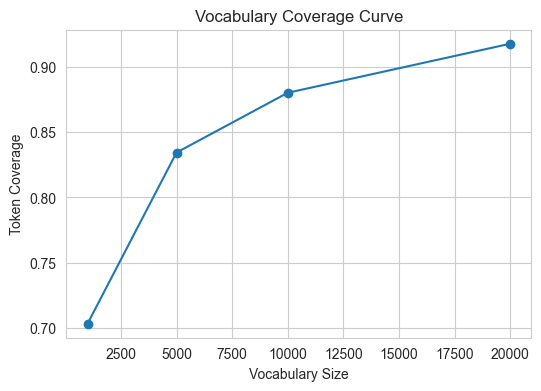

In [18]:
plt.figure(figsize=(6,4))
plt.plot(coverage_df['Top-K Words'], coverage_df['Token Coverage'], marker='o')
plt.title("Vocabulary Coverage Curve")
plt.ylabel("Token Coverage")
plt.xlabel("Vocabulary Size")
plt.show()


In [19]:
# Discriminative words (log-odds)
  
vectorizer = CountVectorizer(
    min_df=50,
    token_pattern=r'(?u)\b[a-z][a-z]+\b'
)
X = vectorizer.fit_transform(df["clean_review"])
vocab = vectorizer.get_feature_names_out()

pos_mask = (df["sentiment"] == 1).to_numpy()
neg_mask = (df["sentiment"] == 0).to_numpy()

pos_counts = X[pos_mask].sum(axis=0).A1
neg_counts = X[neg_mask].sum(axis=0).A1

log_odds = np.log((pos_counts + 1) / (neg_counts + 1))
log_odds_df = pd.DataFrame({"word": vocab, "log_odds": log_odds})

top_positive_words = log_odds_df.sort_values("log_odds", ascending=False).head(20)
top_negative_words = log_odds_df.sort_values("log_odds", ascending=True).head(20)

display(top_positive_words)
display(top_negative_words)

,word,log_odds
2816,edie,3.004031
3340,felix,2.873565
5507,matthau,2.856470
2851,eisenstein,2.790288
3102,excellently,2.740840
7078,raoul,2.533697
3282,farley,2.505526
2431,devito,2.468100
5711,miyazaki,2.380703
4000,haines,2.311635


,word,log_odds
9511,uwe,-4.356709
955,boll,-4.257974
5425,manos,-4.158883
8532,stinker,-2.963397
3561,forwarding,-2.961831
9304,turd,-2.736221
8495,steaming,-2.708050
8627,stunk,-2.691243
9724,waste,-2.680486
12,abomination,-2.614960


In [20]:
# Negtaions & stopword ratio

negations = {
    "not", "no", "never", 
    "don't", "dont", "didn't","didnt", "isn't", "isnt", "wasn't", "wasnt",
    "can't", "cant", "won't", "wont", "couldn't", "couldnt", "shouldn't", "shouldnt"
}

df['negation_count'] = df['clean_review'].apply(
    lambda x: sum(word in negations for word in x.split())
)

negation_stats = (df.groupby('sentiment')['negation_count']
               .mean()
               .rename(index={1:'Positive',0:'Negative'}))
display(negation_stats)

sentiment
Negative    3.21676
Positive    2.41776
Name: negation_count, dtype: float64

In [21]:
df['stopword_ratio'] = df['clean_review'].apply(
    lambda x: np.mean([word in stop_words for word in x.split()])
)

stopword_stats = (df.groupby('sentiment')['stopword_ratio'].mean()
                     .rename(index={1:'Positive',0:'Negative'}))
display(stopword_stats)

sentiment
Negative    0.464169
Positive    0.461148
Name: stopword_ratio, dtype: float64

## Task 2: Text Preprocessor


In [47]:
class TextPreprocessor:
    def __init__(self, 
                 remove_html: bool = True,
                 lowercase: bool = True,
                 remove_punctuation: bool = False,
                 remove_stopwords: bool = False,
                 lemmatize: bool = False,
                 expand_contractions: bool = True):
        self.remove_html = remove_html
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.expand_contractions = expand_contractions

        # Pre-load resources to optimize runtime
        self.stop_words = set(stopwords.words('english'))
        self.stop_words.remove("not")
        self.lemmatizer = WordNetLemmatizer()
        
        # Simple contraction map for expansion
        self.contractions_dict = {
            "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
            "haven't": "have not", "hasn't": "has not", "hadn't": "had not", "won't": "will not",
            "wouldn't": "would not", "don't": "do not", "doesn't": "does not", "didn't": "did not",
            "can't": "cannot", "couldn't": "could not", "shouldn't": "should not", "mightn't": "might not",
            "mustn't": "must not", "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
            "it's": "it is", "we're": "we are", "they're": "they are", "i've": "i have", "you've": "you have",
            "we've": "we have", "they've": "they have", "i'll": "i will", "you'll": "you will",
            "he'll": "he will", "she'll": "she will", "we'll": "we will", "they'll": "they will"
        }
        self.contractions_re = re.compile('(%s)' % '|'.join(self.contractions_dict.keys()))
        # Normalization Regexes
        self.whitespace_re = re.compile(r'\s+')
        self.apostrophe_re = re.compile(r"[’`´]")

    def _clean_html(self, text: str) -> str:
        """Removes HTML tags and unescapes HTML entities."""
        text = html.unescape(text)
        clean = re.compile('<.*?>')
        return re.sub(clean, ' ', text)

    def _expand_contractions(self, text: str) -> str:
        """Expands common English contractions."""
        def replace(match):
            return self.contractions_dict[match.group(0)]
        return self.contractions_re.sub(replace, text)

    def _remove_punct(self, text: str) -> str:
        """Removes punctuation by replacing it with spaces."""
        return re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

    def _normalize_whitespace(self, text: str) -> str:
        """Collapse whitespace and strip edges."""
        return self.whitespace_re.sub(" ", text).strip()

    def _normalize_apostrophes(self, text: str) -> str:
        """Normalize fancy apostrophes to standard one."""
        return self.apostrophe_re.sub("'", text)

    def process_text(self, text: str) -> Union[str, List[str]]:
        """
        Main execution method.
        """
        if not isinstance(text, str) or not text:
            return ""

        #  Cleaning
        if self.remove_html:
            text = self._clean_html(text)
        
        #  Normalization
        text = self._normalize_apostrophes(text)
        text = self._normalize_whitespace(text)

        #  Lowercasing
        if self.lowercase:
            text = text.lower()
            
        #  Expansion
        if self.expand_contractions:
            text = self._expand_contractions(text)

        #  Punctuation Removal
        if self.remove_punctuation:
            text = self._remove_punct(text)

        #  Tokenization
        tokens = word_tokenize(text)

        #  Stopword Removal
        if self.remove_stopwords:
            tokens = [w for w in tokens if w not in self.stop_words]

        #  Lemmatization
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(w) for w in tokens]

        return " ".join(tokens)


## Task 3: N-gram & LSTM

In [48]:
# Load Data
try:
    df = pd.read_csv('IMDB Dataset.csv')
    raw_reviews = df['review'].tolist()
    print(f"Loaded {len(raw_reviews)} reviews.")
except FileNotFoundError:
    print("IMDB Dataset.csv not found. Using dummy data.")
    raw_reviews = ["The movie was terrible.", "I loved the film. It was great.", "The acting was bad."] * 100

# Configuration
SAMPLE_SIZE = len(raw_reviews)  
raw_reviews = raw_reviews[:SAMPLE_SIZE]

Loaded 50000 reviews.


In [49]:
# 1. Pipeline for N-gram Models
print("Preprocessing for N-gram models...")
ngram_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=True, # Keep structure for n-grams
    remove_stopwords=False, 
    lemmatize=True, 
    expand_contractions=True
)


ngram_corpus = []
for r in raw_reviews:
    cleaned = ngram_prep.process_text(r)
    tokens = cleaned.split()
    tokens = ['<s>', '<s>'] + tokens + ['</s>']
    ngram_corpus.append(tokens)
print("Done.")

Preprocessing for N-gram models...
Done.


In [50]:
# 2. Pipeline for Neural Model
print("Preprocessing for Neural models...")
neural_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=False,
    remove_stopwords=False, 
    lemmatize=False,
    expand_contractions=True
)

neural_corpus = []
MAX_LEN = 100
for r in raw_reviews:
    cleaned = neural_prep.process_text(r)
    tokens = cleaned.split()
    tokens = ['<s>'] + tokens[:MAX_LEN] + ['</s>']
    neural_corpus.append(tokens)
print("Done.")

Preprocessing for Neural models...
Done.


In [51]:
# Split 
split_idx = int(len(raw_reviews) * 0.8)

train_ngram = ngram_corpus[:split_idx]
test_ngram  = ngram_corpus[split_idx:]

train_neural = neural_corpus[:split_idx]
test_neural  = neural_corpus[split_idx:]

print(f"Data ready. Train size: {len(train_ngram)}, Test size: {len(test_ngram)}")

Data ready. Train size: 40000, Test size: 10000


In [52]:
#3. Pipeline for Transformer (Sentiment Classification)
print("Preprocessing for Transformer models...")
transformer_prep = TextPreprocessor(
    remove_html=True, 
    lowercase=True, 
    remove_punctuation=False, 
    remove_stopwords=False, 
    lemmatize=False,
    expand_contractions=False
)

transformer_reviews = []
labels = []

if 'sentiment' in df.columns:
    sentiment_map = {'positive': 1, 'negative': 0}
    labels = df['sentiment'].map(sentiment_map).tolist()[:SAMPLE_SIZE]
else:
    print("Warning: 'sentiment' column not found. Creating dummy labels.")
    labels = [0] * len(raw_reviews) # Dummy

for r in raw_reviews:
    clean_text = transformer_prep.process_text(r)
    transformer_reviews.append(clean_text)

train_transformer = transformer_reviews[:split_idx]
test_transformer  = transformer_reviews[split_idx:]
train_labels = labels[:split_idx]
test_labels = labels[split_idx:]
print("Done.")

Preprocessing for Transformer models...
Done.


### Model Definitions


In [53]:
# Shared Mixins for N-gram Models
class BigramMixin:

    def calculate_perplexity(self, test_corpus):
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                prob = self.get_probability(w_curr, w_next)
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0:
            return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        current_word = "<s>"
        sentence = [current_word]
        
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            if not possible_next:
                break

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            sentence.append(next_word)
            current_word = next_word
            
        return " ".join(sentence[1:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        if not tokens:
            current_word = "<s>"
        else:
            current_word = tokens[-1]
            
        # Handle OOV for the seed word
        if current_word not in self.vocab:
            current_word = "<UNK>"
            
        generated_tokens = []
        for _ in range(max_length):
            if current_word == "</s>":
                break
            
            possible_next = self.bigram_counts[current_word]
            if not possible_next:
                current_word = "<UNK>"
                possible_next = self.bigram_counts[current_word]
            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_word = next_word
            
        return prompt + " " + " ".join(generated_tokens)


class TrigramMixin:

    def calculate_perplexity(self, test_corpus):
        log_prob_sum = 0
        N = 0
        
        for sentence in test_corpus:
            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                prob = self.get_probability(w_1, w_2, w_3)
                log_prob_sum += math.log2(prob)
                N += 1
        
        if N == 0:
            return float('inf')
        
        avg_log_prob = -log_prob_sum / N
        perplexity = 2 ** avg_log_prob
        return perplexity

    def generate_sentence(self, max_length=20):
        current_w1 = "<s>"
        current_w2 = "<s>"
        sentence = [current_w1, current_w2]
        
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            if not possible_next:
                break 

            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            sentence.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        return " ".join(sentence[2:])

    def autocomplete(self, prompt, preprocessor, max_length=20):
        cleaned_prompt = preprocessor.process_text(prompt)
        tokens = cleaned_prompt.split()
        
        if len(tokens) >= 2:
            current_w1 = tokens[-2]
            current_w2 = tokens[-1]
        elif len(tokens) == 1:
            current_w1 = "<s>"
            current_w2 = tokens[-1]
        else:
            current_w1 = "<s>"
            current_w2 = "<s>"

        generated_tokens = []
        for _ in range(max_length):
            if current_w2 == "</s>":
                break
            
            possible_next = self.trigram_counts[(current_w1, current_w2)]
            if not possible_next:
                break
                
            candidates = list(possible_next.keys())
            counts = list(possible_next.values())
            next_word = random.choices(candidates, weights=counts, k=1)[0]
            
            generated_tokens.append(next_word)
            current_w1 = current_w2
            current_w2 = next_word
            
        return prompt + " ".join(generated_tokens)


### Bigram Model


In [54]:
class BigramLanguageModel(BigramMixin):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        self.total_bigrams = 0
        self.total_unigrams = 0
        
        self.lambda1 = 0.3  # Unigram
        self.lambda2 = 0.7  # Bigram
        
    def train(self, corpus):
        print("Training model on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                self.total_unigrams += 1
            
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                self.bigram_counts[w_curr][w_next] += 1
                self.total_bigrams += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, prev_word, word):
        # Bigram probability
        bigram_count = self.bigram_counts[prev_word][word]
        unigram_count_prev = self.unigram_counts[prev_word]
        
        p_bi_num = bigram_count + self.alpha
        p_bi_den = unigram_count_prev + (self.alpha * self.vocab_size)
        p_bi = p_bi_num / p_bi_den
        
        # Unigram probability
        unigram_count_word = self.unigram_counts[word]
        p_uni_num = unigram_count_word + self.alpha
        p_uni_den = self.total_unigrams + (self.alpha * self.vocab_size)
        p_uni = p_uni_num / p_uni_den
        
        return (self.lambda2 * p_bi) + (self.lambda1 * p_uni)


In [55]:
class SimpleBigramLanguageModel(BigramMixin):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        
    def train(self, corpus):
        print("Training Simple Bigram on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
            
            for i in range(len(sentence) - 1):
                w_curr = sentence[i]
                w_next = sentence[i+1]
                self.bigram_counts[w_curr][w_next] += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Simple Bigram Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, prev_word, word):
        bigram_count = self.bigram_counts[prev_word][word]
        unigram_count_prev = self.unigram_counts[prev_word]
        
        num = bigram_count + self.alpha
        den = unigram_count_prev + (self.alpha * self.vocab_size)
        return num / den


### Trigram Model


In [56]:
class TrigramLanguageModel(TrigramMixin):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(int)
        self.unigram_counts = defaultdict(int)
        
        self.vocab = set()
        self.vocab_size = 0
        self.total_trigrams = 0
        self.total_unigrams = 0
        
        self.lambda1 = 0.1  # Unigram
        self.lambda2 = 0.3  # Bigram
        self.lambda3 = 0.6  # Trigram
        
    def train(self, corpus):
        print("Training model on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                self.total_unigrams += 1
            
            for i in range(len(sentence) - 1):
                self.bigram_counts[(sentence[i], sentence[i+1])] += 1

            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                
                self.trigram_counts[(w_1, w_2)][w_3] += 1
                self.total_trigrams += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, w_1, w_2, w_3):
        # Trigram prob
        trigram_count = self.trigram_counts[(w_1, w_2)][w_3]
        bigram_context_count = self.bigram_counts[(w_1, w_2)]
        
        p_tri_num = trigram_count + self.alpha
        p_tri_den = bigram_context_count + (self.alpha * self.vocab_size)
        p_tri = p_tri_num / p_tri_den
        
        # Bigram prob (backoff)
        bigram_count = self.bigram_counts[(w_2, w_3)]
        unigram_context_count = self.unigram_counts[w_2]
        
        p_bi_num = bigram_count + self.alpha
        p_bi_den = unigram_context_count + (self.alpha * self.vocab_size)
        p_bi = p_bi_num / p_bi_den
        
        # Unigram prob
        unigram_count = self.unigram_counts[w_3]
        p_uni_num = unigram_count + self.alpha
        p_uni_den = self.total_unigrams + (self.alpha * self.vocab_size)
        p_uni = p_uni_num / p_uni_den
        
        return (self.lambda3 * p_tri) + (self.lambda2 * p_bi) + (self.lambda1 * p_uni)


In [57]:
class SimpleTrigramLanguageModel(TrigramMixin):
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.trigram_counts = defaultdict(lambda: defaultdict(int))
        self.bigram_counts = defaultdict(int)
        self.vocab = set()
        self.vocab_size = 0
        
    def train(self, corpus):
        print("Training Simple Trigram on full vocabulary...")
        for sentence in corpus:
            for word in sentence:
                self.vocab.add(word)
            
            for i in range(len(sentence) - 1):
                self.bigram_counts[(sentence[i], sentence[i+1])] += 1

            for i in range(len(sentence) - 2):
                w_1 = sentence[i]
                w_2 = sentence[i+1]
                w_3 = sentence[i+2]
                self.trigram_counts[(w_1, w_2)][w_3] += 1
                
        self.vocab_size = len(self.vocab)
        print(f"Simple Trigram Training complete. Vocab size: {self.vocab_size}")

    def get_probability(self, w_1, w_2, w_3):
        trigram_count = self.trigram_counts[(w_1, w_2)][w_3]
        bigram_context_count = self.bigram_counts[(w_1, w_2)]
        
        num = trigram_count + self.alpha
        den = bigram_context_count + (self.alpha * self.vocab_size)
        return num / den


### Neural Model (LSTM)


In [58]:
class Vocabulary:
    def __init__(self, token_to_idx=None):
        if token_to_idx:
            self.token_to_idx = token_to_idx
        else:
            self.token_to_idx = {"<PAD>": 0, "<UNK>": 1, "<s>": 2, "</s>": 3}
        self.idx_to_token = {v: k for k, v in self.token_to_idx.items()}
        
    def build_vocab(self, sentences, min_freq=2):
        print("Building vocabulary...")
        all_tokens = [token for sent in sentences for token in sent]
        counts = Counter(all_tokens)
        
        for token, count in counts.items():
            if count >= min_freq and token not in self.token_to_idx:
                self.token_to_idx[token] = len(self.token_to_idx)
                
        self.idx_to_token = {v: k for k, v in self.token_to_idx.items()}
        print(f"Vocabulary size: {len(self.token_to_idx)}")
        
    def __len__(self):
        return len(self.token_to_idx)
    
    def stoi(self, token):
        return self.token_to_idx.get(token, self.token_to_idx["<UNK>"])
        
    def itos(self, idx):
        return self.idx_to_token.get(idx, "<UNK>")

In [59]:
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, sentences, vocab):
        self.sentences = sentences
        self.vocab = vocab
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokenized_sent = self.sentences[idx]
        # Numericalize
        indexed = [self.vocab.stoi(t) for t in tokenized_sent]
        return torch.tensor(indexed, dtype=torch.long)

def collate_fn(batch):
    """
    Custom collate function to handle variable length sentences via padding.
    """
    batch.sort(key=lambda x: len(x), reverse=True)
    inputs = [item[:-1] for item in batch]
    targets = [item[1:] for item in batch]
    
    lengths = torch.tensor([len(x) for x in inputs], dtype=torch.long)
    
    # Pad sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0)
    
    return inputs_padded, targets_padded, lengths

In [60]:
class NeuralLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(NeuralLM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, lengths=None, hidden=None):
        # x: (batch, seq_len)
        embed = self.embedding(x) # (batch, seq_len, embed_dim)
        
        if lengths is not None:
            # Pack
            packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True, enforce_sorted=True)
            packed_out, hidden = self.lstm(packed_embed, hidden)
            # Unpack
            output, _ = pad_packed_sequence(packed_out, batch_first=True)
        else:
            # No packing 
            output, hidden = self.lstm(embed, hidden)
        logits = self.fc(output) 
        return logits, hidden

In [61]:
def generate_text(model, vocab, start_prompt="The movie", max_len=20, device='cpu', temperature=1.0):
    model.eval()
    preprocessor = TextPreprocessor(lowercase=True)
    tokens = preprocessor.process_text(start_prompt).split()
    
    current_idx = [vocab.stoi(t) for t in tokens]
    
    input_seq = torch.tensor(current_idx, dtype=torch.long).unsqueeze(0).to(device) 
    
    generated = list(tokens)
    
    hidden = None
    
    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_seq, hidden=hidden)
            
            # Get last time step
            last_logits = logits[0, -1, :]
            
            # Apply temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature
                
            probs = torch.softmax(last_logits, dim=0)
            
            # Sample
            next_token_idx = torch.multinomial(probs, 1).item()
            next_token = vocab.itos(next_token_idx)
            
            if next_token == "</s>":
                break
                
            generated.append(next_token)
            input_seq = torch.tensor([[next_token_idx]], dtype=torch.long).to(device)
            
    return " ".join(generated)

### Comparison: Bigram vs Trigram
We compare the perplexity and generation quality of the statistical models.


In [62]:
# Initialize
bigram_model = BigramLanguageModel(alpha=0.01)
simple_bigram_model = SimpleBigramLanguageModel(alpha=0.01)
trigram_model = TrigramLanguageModel(alpha=0.01)
simple_trigram_model = SimpleTrigramLanguageModel(alpha=0.01)

In [63]:
# Train Bigram
print("Training Bigram...")
start = time.time()
train_bi_adapted = [s[1:] for s in train_ngram] 
test_bi_adapted = [s[1:] for s in test_ngram]
bigram_model.train(train_bi_adapted)
bigram_time = time.time() - start
print(f"Bigram Trained in {bigram_time:.4f}s")

Training Bigram...
Training model on full vocabulary...
Training complete. Vocab size: 84480
Bigram Trained in 5.8208s


In [64]:
# Train Simple Bigram
print("Training Simple Bigram...")
start = time.time()
simple_bigram_model.train(train_bi_adapted)
simple_bigram_time = time.time() - start
print(f"Simple Bigram Trained in {simple_bigram_time:.4f}s")

Training Simple Bigram...
Training Simple Bigram on full vocabulary...
Simple Bigram Training complete. Vocab size: 84480
Simple Bigram Trained in 5.3418s


In [ ]:
# Train Trigram
print("Training Trigram...")
start = time.time()
trigram_model.train(train_ngram)
trigram_time = time.time() - start
print(f"Trigram Trained in {trigram_time:.4f}s")

Training Trigram...
Training model on full vocabulary...


In [ ]:
# Train Simple Trigram
print("Training Simple Trigram...")
start = time.time()
simple_trigram_model.train(train_ngram)
simple_trigram_time = time.time() - start
print(f"Simple Trigram Trained in {simple_trigram_time:.4f}s")

In [ ]:
# Perplexity
pp_bi = bigram_model.calculate_perplexity(test_bi_adapted)
pp_simple_bi = simple_bigram_model.calculate_perplexity(test_bi_adapted)
pp_tri = trigram_model.calculate_perplexity(test_ngram)
pp_simple_tri = simple_trigram_model.calculate_perplexity(test_ngram)

print(f"\nBigram Perplexity: {pp_bi:.2f}")
print(f"Simple Bigram Perplexity: {pp_simple_bi:.2f}")
print(f"Trigram Perplexity: {pp_tri:.2f}")
print(f"Simple Trigram Perplexity: {pp_simple_tri:.2f}")

In [ ]:
# Generation Comparison
print("\n--- Generation Comparison (Unprompted) ---")
print("Bigram:")
for i in range(2):
    print(f"  {i+1}. {bigram_model.generate_sentence()}")
print("Simple Bigram:")
for i in range(2):
    print(f"  {i+1}. {simple_bigram_model.generate_sentence()}")

print("\nTrigram:")
for i in range(2):
    print(f"  {i+1}. {trigram_model.generate_sentence()}")
print("Simple Trigram:")
for i in range(2):
    print(f"  {i+1}. {simple_trigram_model.generate_sentence()}")

### Comprehensive Comparison (LSTM vs N-grams)
Comparing Logic, Training Time, and Perplexity.


In [ ]:
# Train Neural Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training Neural Model on {device}...")

# Config
EMBED_DIM = 64
HIDDEN_DIM = 512
BATCH_SIZE = 64
LEARNING_RATE = 0.005
NUM_EPOCHS = 6 

# Setup
vocab = Vocabulary()
vocab.build_vocab(train_neural, min_freq=2) # => lowers perplexity and decreases train time
dataset = IMDBDataset(train_neural, vocab)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

model_lstm = NeuralLM(len(vocab), EMBED_DIM, HIDDEN_DIM).to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
# Training Loop
start = time.time()
model_lstm.train()
loss_history = []

print(f"Starting Training. ")
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for inputs, targets, lengths in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits, _ = model_lstm(inputs, lengths)
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    navg = epoch_loss / len(dataloader)
    loss_history.append(navg)
    print(f"Epoch {epoch+1}: Loss {navg:.4f}")

neural_time = time.time() - start
print(f"Neural Trained in {neural_time:.4f}s")

In [ ]:
# Neural Perplexity (Approximate on Test Set)
test_ds = IMDBDataset(test_neural, vocab)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
model_lstm.eval()
total_n_loss = 0
total_batches = 0
with torch.no_grad():
    for inputs, targets, lengths in test_dl:
        inputs, targets = inputs.to(device), targets.to(device)
        logits, _ = model_lstm(inputs, lengths)
        # Loss per batch
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        total_n_loss += loss.item()
        total_batches += 1

avg_test_loss = total_n_loss / total_batches if total_batches > 0 else 999
pp_neural = math.exp(avg_test_loss)
print(f"Neural Perplexity: {pp_neural:.2f}")

### Performance Visualization


In [ ]:

models = ['Bigram', 'Simple Bi', 'Trigram', 'Simple Tri', 'LSTM']
times = [bigram_time, simple_bigram_time, trigram_time, simple_trigram_time, neural_time]
perplexities = [pp_bi, pp_simple_bi, pp_tri, pp_simple_tri, pp_neural]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time Plot
sns.barplot(x=models, y=times, hue=models, ax=axes[0], palette="viridis", legend=False)
axes[0].set_title("Training Time (seconds)")
axes[0].set_ylabel("Seconds")
for i, v in enumerate(times):
    axes[0].text(i, v + 0.1, f"{v:.1f}s", ha='center')

sns.barplot(x=models, y=perplexities, hue=models, ax=axes[1], palette="magma", legend=False)
axes[1].set_title("Test Perplexity (Lower is Better)")
axes[1].set_ylabel("Perplexity")
for i, v in enumerate(perplexities):
    axes[1].text(i, v + 1, f"{v:.1f}", ha='center')

plt.tight_layout()
plt.show()



### Qualitative Comparison: Text Generation
Comparing outputs with and without prompts.


In [ ]:

prompts = [None, "The movie was", "I thought that"]

def get_continuation(model_type, prompt):
    if prompt is None:
        if model_type == 'LSTM':
            return generate_text(model_lstm, vocab, "The", device=device)
        elif model_type == 'Bigram':
            return bigram_model.generate_sentence()
        elif model_type == 'Simple Bi':
            return simple_bigram_model.generate_sentence()
        elif model_type == 'Trigram':
            return trigram_model.generate_sentence()
        elif model_type == 'Simple Tri':
            return simple_trigram_model.generate_sentence()
    else:
        # Prompted
        if model_type == 'LSTM':
            return generate_text(model_lstm, vocab, prompt, device=device)
        elif model_type == 'Bigram':
            return bigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Simple Bi':
            return simple_bigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Trigram':
            return trigram_model.autocomplete(prompt, ngram_prep)
        elif model_type == 'Simple Tri':
            return simple_trigram_model.autocomplete(prompt, ngram_prep)

results = []
for p in prompts:
    p_label = p if p else "Unprompted"
    row = {"Prompt": p_label}
    row["Bigram"] = get_continuation('Bigram', p)
    row["Simple Bi"] = get_continuation('Simple Bi', p)
    row["Trigram"] = get_continuation('Trigram', p)
    row["Simple Tri"] = get_continuation('Simple Tri', p)
    row["LSTM"] = get_continuation('LSTM', p)
    results.append(row)

res_df = pd.DataFrame(results)
pd.set_option('display.max_colwidth', None)
display(res_df)



# Task 4: Transformer Fine-tuning

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


In [ ]:
# Create Dataset from our preprocessed text

train_dataset = Dataset.from_dict({'text': train_transformer, 'label': train_labels})
test_dataset = Dataset.from_dict({'text': test_transformer, 'label': test_labels})

train_val_split = train_dataset.train_test_split(test_size=0.1, seed=42)

hf_dataset = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': test_dataset
})

print(hf_dataset)


In [ ]:
metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


In [ ]:
# MiniLM: small BERT-like model with WordPiece tokenization
model_name_minilm = "microsoft/MiniLM-L12-H384-uncased"

tokenizer_minilm = AutoTokenizer.from_pretrained(model_name_minilm)

MAX_LENGTH = 256  

def tokenize_minilm(batch):
    return tokenizer_minilm(
        batch["text"],
        truncation=True,        # cut off longer sequences
        max_length=MAX_LENGTH,  
        padding=False           # padding handled below
    )


tokenized_minilm = hf_dataset.map(tokenize_minilm, batched=True)
tokenized_minilm


In [ ]:
data_collator_minilm = DataCollatorWithPadding(tokenizer=tokenizer_minilm)

model_minilm = AutoModelForSequenceClassification.from_pretrained(
    model_name_minilm,
    num_labels=2
).to(device)


In [ ]:
train_minilm = tokenized_minilm["train"].shuffle(seed=42)
val_minilm   = tokenized_minilm["validation"].shuffle(seed=42)

In [ ]:
training_args_minilm = TrainingArguments(
    output_dir="./minilm_sentiment",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,        
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=False,  
)

trainer_minilm = Trainer(
    model=model_minilm,
    args=training_args_minilm,
    train_dataset=train_minilm,
    eval_dataset=val_minilm,
    tokenizer=tokenizer_minilm,
    data_collator=data_collator_minilm,
    compute_metrics=compute_metrics,
)


In [ ]:
train_result_minilm = trainer_minilm.train()
eval_minilm_val = trainer_minilm.evaluate()

print("MiniLM (validation) metrics:")
print(eval_minilm_val)


In [ ]:
pred_test_minilm = trainer_minilm.predict(tokenized_minilm["test"])
logits_test_minilm = pred_test_minilm.predictions
labels_test_minilm = pred_test_minilm.label_ids
pred_labels_minilm = logits_test_minilm.argmax(axis=-1)

acc_test_minilm = metric_acc.compute(predictions=pred_labels_minilm, references=labels_test_minilm)
f1_test_minilm = metric_f1.compute(predictions=pred_labels_minilm, references=labels_test_minilm, average="macro")

print("MiniLM Test Accuracy:", acc_test_minilm)
print("MiniLM Test Macro-F1:", f1_test_minilm)

cm_minilm = confusion_matrix(labels_test_minilm, pred_labels_minilm)

print("\n=== Confusion Matrix (Text) ===")
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print(f"{'Actual Negative':20} {cm_minilm[0, 0]:>20} {cm_minilm[0, 1]:>20}")
print(f"{'Actual Positive':20} {cm_minilm[1, 0]:>20} {cm_minilm[1, 1]:>20}")

disp_minilm = ConfusionMatrixDisplay(confusion_matrix=cm_minilm, display_labels=["negative", "positive"])
disp_minilm.plot(cmap="Blues")
plt.title("MiniLM Confusion Matrix (Test)")
plt.show()


In [ ]:
model_name_bpe = "distilroberta-base"

tokenizer_bpe = AutoTokenizer.from_pretrained(model_name_bpe)


def tokenize_bpe(batch):
    return tokenizer_bpe(
        batch["text"],
        truncation=True,
        padding="max_length",   # or "longest" if you prefer dynamic padding
        max_length=MAX_LENGTH,
    )

tokenized_bpe = hf_dataset.map(tokenize_bpe, batched=True)

tokenized_bpe


In [ ]:
# Remove the original text column(s) so Trainer only sees tensors + labels
tokenized_bpe = tokenized_bpe.remove_columns(["text"])

# Make sure labels are called "labels" for Trainer
tokenized_bpe = tokenized_bpe.rename_column("label", "labels")

# Set to torch format
tokenized_bpe.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [ ]:
train_small_bpe = tokenized_bpe["train"].shuffle(seed=42).select(range(8000))
val_small_bpe   = tokenized_bpe["validation"].shuffle(seed=42).select(range(2000))


In [ ]:
num_labels = 2  # binary sentiment
id2label = {0: "negative", 1: "positive"}
label2id = {"negative": 0, "positive": 1}

model_bpe = AutoModelForSequenceClassification.from_pretrained(
    model_name_bpe,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

training_args_bpe = TrainingArguments(
    output_dir="./distilroberta_sentiment",
    eval_strategy="epoch",  
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    seed=42,
)

trainer_bpe = Trainer(
    model=model_bpe,
    args=training_args_bpe,
    train_dataset=train_small_bpe,
    eval_dataset=val_small_bpe,
    tokenizer=tokenizer_bpe,
    compute_metrics=compute_metrics,
)



In [ ]:
train_result_bpe = trainer_bpe.train()
eval_bpe_val = trainer_bpe.evaluate()

print("DistilRoBERTa (validation) metrics:")
print(eval_bpe_val)

In [ ]:
pred_test_bpe = trainer_bpe.predict(tokenized_bpe["test"])
logits_test_bpe = pred_test_bpe.predictions
labels_test_bpe = pred_test_bpe.label_ids
pred_labels_bpe = logits_test_bpe.argmax(axis=-1)

acc_test_bpe = metric_acc.compute(predictions=pred_labels_bpe, references=labels_test_bpe)
f1_test_bpe = metric_f1.compute(predictions=pred_labels_bpe, references=labels_test_bpe, average="macro")

print("DistilRoBERTa Test Accuracy:", acc_test_bpe)
print("DistilRoBERTa Test Macro-F1:", f1_test_bpe)
cm_bpe = confusion_matrix(labels_test_bpe, pred_labels_bpe)

print("\n=== Confusion Matrix (Text) ===")
print(f"{'':20} {'Predicted Negative':>20} {'Predicted Positive':>20}")
print(f"{'Actual Negative':20} {cm_bpe[0, 0]:>20} {cm_bpe[0, 1]:>20}")
print(f"{'Actual Positive':20} {cm_bpe[1, 0]:>20} {cm_bpe[1, 1]:>20}")

disp_bpe = ConfusionMatrixDisplay(confusion_matrix=cm_bpe, display_labels=["negative", "positive"])
disp_bpe.plot(cmap="Greens")
plt.title("DistilRoBERTa Confusion Matrix (Test)")
plt.show()


In [ ]:

# Label id ↔ name mapping
id2label = {0: "negative", 1: "positive"}

def show_minilm_predictions(
    num_examples: int = 5,
    split: str = "test",
    max_review_chars: int = 300,
):
    """
    Print a few test reviews with:
    - gold label
    - predicted label
    - prediction probability
    """
    # HuggingFace test datasets
    ds_text = hf_dataset[split]          # original text + labels
    ds_tok  = tokenized_minilm[split]    # tokenized for MiniLM

    # Take first `num_examples` 
    indices = list(range(min(num_examples, len(ds_tok))))
    small_tok_ds = ds_tok.select(indices)

    # Use Trainer to predict on this small subset
    preds = trainer_minilm.predict(small_tok_ds)
    logits = preds.predictions           # shape (N, 2) for binary classification
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()

    for i, idx in enumerate(indices):
        ex = ds_text[idx]
        text = ex["text"]
        gold = id2label[ex["label"]]
        pred_id = int(probs[i].argmax())
        pred_label = id2label[pred_id]
        pred_prob = float(probs[i][pred_id])

        print("=" * 100)
        print(f"Example {i+1} (index={idx})")
        print(f"Gold label      : {gold}")
        print(f"Predicted label : {pred_label}  (p = {pred_prob:.3f})")
        print("-" * 100)
        # Show truncated text for readability
        if len(text) > max_review_chars:
            print(text[:max_review_chars] + "...")
        else:
            print(text)
        print()  # blank line

show_minilm_predictions(num_examples=5)

## Task 4: Model Evaluation & Benchmarking

In [ ]:

N_SAMPLE = 100
SEED = 42

random.seed(SEED)
indices_100 = random.sample(range(len(hf_dataset["test"])), k=N_SAMPLE)

sample_text_ds = hf_dataset["test"].select(indices_100)          # original text + gold labels
sample_tok_ds   = tokenized_minilm["test"].select(indices_100)   # tokenized for MiniLM

len(sample_text_ds), len(sample_tok_ds)


In [ ]:
# Run MiniLM on the 100-tokenized samples
preds_100 = trainer_minilm.predict(sample_tok_ds)
logits_100 = preds_100.predictions
labels_100 = preds_100.label_ids
probs_100 = F.softmax(torch.tensor(logits_100), dim=-1).numpy()
pred_labels_100 = probs_100.argmax(axis=-1)

acc_100 = accuracy_score(labels_100, pred_labels_100)
f1_100 = f1_score(labels_100, pred_labels_100, average="macro")

print(f"MiniLM on 100-sample subset:")
print(f"  Accuracy:   {acc_100:.3f}")
print(f"  Macro-F1:   {f1_100:.3f}")


In [ ]:
def simple_classical_tokens(text: str):
    """
    Cleans text using the N-gram preprocessor settings and returns tokens.
    """
    # ngram_prep.process_text returns a single string of space-separated tokens
    cleaned_text = ngram_prep.process_text(text)
    # Split back into a list of tokens
    return cleaned_text.split()
    
# Helper function to add padding consistent with training
def build_ngram_sentences(token_lists, n=2):
    padded_sentences = []
    for tokens in token_lists:
        if n == 2:
            # Bigram model was trained on ['<s>', w1, ..., '</s>'] (See Cell 39 adaptation)
            padded = ['<s>'] + tokens + ['</s>']
        elif n == 3:
            # Trigram model was trained on ['<s>', '<s>', w1, ..., '</s>']
            padded = ['<s>', '<s>'] + tokens + ['</s>']
        else:
            padded = tokens
        padded_sentences.append(padded)
    return padded_sentences

# Generate tokens
sample_tokens_100 = [
    simple_classical_tokens(x["text"])
    for x in sample_text_ds
]

# Build padded sentences
sample_sents_bigram_100  = build_ngram_sentences(sample_tokens_100, n=2)
sample_sents_trigram_100 = build_ngram_sentences(sample_tokens_100, n=3)


# Use the model variable names from Cell 39 (bigram_model, trigram_model)
pp_bigram_100  = bigram_model.calculate_perplexity(sample_sents_bigram_100)
pp_trigram_100 = trigram_model.calculate_perplexity(sample_sents_trigram_100)

print(f"Bigram Perplexity (Subset): {pp_bigram_100:.2f}")
print(f"Trigram Perplexity (Subset): {pp_trigram_100:.2f}")



In [ ]:
# LSTM LM Perplexity on the same 100 texts ---


def tokens_to_ids(token_lists, vocab):
    return [[vocab.stoi(t) for t in tokens] for tokens in token_lists]


sample_tokens_neural_100 = [
    neural_prep.process_text(x["text"]).split()
    for x in sample_text_ds
]

# Add Neural padding: ['<s>'] + tokens + ['</s>'] 
MAX_LEN_NEURAL = 100 
sample_tokens_neural_padded = []
for tokens in sample_tokens_neural_100:
    padded = ['<s>'] + tokens[:MAX_LEN_NEURAL] + ['</s>']
    sample_tokens_neural_padded.append(padded)

# Convert to IDs
sample_ids_100 = tokens_to_ids(sample_tokens_neural_padded, vocab)

# Create Dataset and Loader
sample_dataset_lstm_100 = IMDBDataset(sample_tokens_neural_padded, vocab) 
sample_loader_lstm_100 = DataLoader(
    sample_dataset_lstm_100,
    batch_size=32, # Use a standard batch size
    shuffle=False,
    collate_fn=collate_fn
)

# Evaluate
model_lstm.eval()
total_loss = 0
total_batches = 0
criterion = nn.CrossEntropyLoss(ignore_index=0)

with torch.no_grad():
    for inputs, targets, lengths in sample_loader_lstm_100:
        inputs, targets = inputs.to(device), targets.to(device)
        logits, _ = model_lstm(inputs, lengths)
        loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        total_loss += loss.item()
        total_batches += 1

avg_loss = total_loss / total_batches if total_batches > 0 else 999
pp_lstm_100 = math.exp(avg_loss)

print(f"LSTM Perplexity (Subset): {pp_lstm_100:.2f}")

In [ ]:

print("\n=== Perplexity Comparison (100-sample subset) ===")
print(f"Bigram LM    : {pp_bigram_100:.1f}")
print(f"Trigram LM   : {pp_trigram_100:.1f}")
print(f"LSTM neural LM: {pp_lstm_100:.1f}")


In [ ]:
# Build a DataFrame with text, gold label, model prediction & prob
id2label = {0: "negative", 1: "positive"}

rows = []
for i, ex in enumerate(sample_text_ds):
    text = ex["text"]
    gold = id2label[ex["label"]]
    pred_id = int(pred_labels_100[i])
    pred_label = id2label[pred_id]
    pred_prob = float(probs_100[i, pred_id])

    rows.append({
        "sample_index": indices_100[i],
        "text": text,
        "gold_label": gold,
        "model_label": pred_label,
        "model_confidence": pred_prob,
        # columns for human annotators to fill in:
        "human_label_annotator1": "",
        "human_label_annotator2": "",
        "human_confidence_annotator1": "",
        "human_confidence_annotator2": "",
    })

df_100 = pd.DataFrame(rows)
df_100.to_csv("human_eval_100.csv", index=False)

df_100.head()


In [ ]:
df_annotated = pd.read_csv("human_eval_100.annotated.csv")

# Convert human labels to ids (e.g. using annotator 1)
label2id = {"negative": 0, "positive": 1}

human_labels_1 = df_annotated["human_label_annotator1"].map(label2id)
gold_labels = df_annotated["gold_label"].map(label2id)
model_labels = df_annotated["model_label"].map(label2id)

# Human vs gold
acc_human_vs_gold = accuracy_score(gold_labels, human_labels_1)
f1_human_vs_gold = f1_score(gold_labels, human_labels_1, average="macro")

# Model vs gold (should match acc_100/f1_100)
acc_model_vs_gold = accuracy_score(gold_labels, model_labels)
f1_model_vs_gold = f1_score(gold_labels, model_labels, average="macro")

# Agreement between human and model
acc_model_vs_human = accuracy_score(human_labels_1, model_labels)
f1_model_vs_human = f1_score(human_labels_1, model_labels, average="macro")

print("Human vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_human_vs_gold, f1_human_vs_gold))
print("Model vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_model_vs_gold, f1_model_vs_gold))
print("Model vs human:  acc={:.3f}, macro-F1={:.3f}".format(acc_model_vs_human, f1_model_vs_human))


In [ ]:
disagree_idx = df_annotated[gold_labels != human_labels_1].index
df_annotated.loc[disagree_idx, ["text", "gold_label", "human_label_annotator1", "model_label"]].head()


In [ ]:
judge_rows = []
for i, row in df_100.iterrows():
    text = row["text"]
    model_label = row["model_label"]

    prompt = f"""
You are a strict sentiment annotator.

Read the following movie review and then answer with a single word:
either "positive" or "negative".

Review:
{text}

What is the correct overall sentiment of this review? Answer with only one word: positive or negative.
    """.strip()

    judge_rows.append({
        "sample_index": row["sample_index"],
        "text": text,
        "gold_label": row["gold_label"],
        "model_label": model_label,
        "judge_prompt": prompt,
        "judge_label": ""  # to fill with LLM output
    })

df_judge = pd.DataFrame(judge_rows)
df_judge.to_csv("llm_judge_100_template.csv", index=False)
df_judge.head()


In [ ]:
import ollama  

JUDGE_MODEL_NAME = "llama3.2:latest"

df_judge = pd.read_csv("llm_judge_100_template.csv")

def ask_ollama(prompt: str, model: str, max_tokens: int = 10) -> str:
    """
    Call Ollama's /chat endpoint via the Python client.
    Returns the model's text response.
    """
    response = ollama.chat(
        model=model,
        messages=[
            {"role": "user", "content": prompt}
        ],
        options={
            "num_predict": max_tokens,
            "temperature": 0.0,  # deterministic, similar to do_sample=False
        },
    )
    # For chat, the text is in response["message"]["content"]
    return response["message"]["content"]

def extract_label_from_response(text: str) -> str:
    text_low = text.lower()
    if "positive" in text_low and "negative" not in text_low:
        return "positive"
    if "negative" in text_low and "positive" not in text_low:
        return "negative"
    # fallback (you can improve this)
    return "positive" if "positive" in text_low else "negative"

judge_labels = []
for prompt in df_judge["judge_prompt"]:
    out = ask_ollama(prompt, JUDGE_MODEL_NAME, max_tokens=10)
    label = extract_label_from_response(out)
    judge_labels.append(label)

df_judge["judge_label"] = judge_labels
df_judge.to_csv("llm_judge_100_annotated.csv", index=False)

print("Saved to llm_judge_100_annotated.csv")


In [ ]:
df_judge_annotated = pd.read_csv("llm_judge_100_annotated.csv")

judge_labels = df_judge_annotated["judge_label"].map(label2id)
gold_labels  = df_judge_annotated["gold_label"].map(label2id)
model_labels = df_judge_annotated["model_label"].map(label2id)

# Judge vs gold
acc_judge_vs_gold = accuracy_score(gold_labels, judge_labels)
f1_judge_vs_gold = f1_score(gold_labels, judge_labels, average="macro")

# Judge vs model
acc_judge_vs_model = accuracy_score(model_labels, judge_labels)
f1_judge_vs_model = f1_score(model_labels, judge_labels, average="macro")

print("LLM-judge vs gold:   acc={:.3f}, macro-F1={:.3f}".format(acc_judge_vs_gold, f1_judge_vs_gold))
print("LLM-judge vs model:  acc={:.3f}, macro-F1={:.3f}".format(acc_judge_vs_model, f1_judge_vs_model))
